# Lab 3: EM and VAE

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 24, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts before you send them!

$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included.

In [2]:
%pylab inline
import cPickle, gzip

# load data
with gzip.open('mnist_small.gz', 'r') as f:
    mnist_images, mnist_labels = cPickle.load(f)

mnist_dim = (28, 28)
print "MNIST data loaded;", \
    " number of samples:", len(mnist_labels), \
    '; number of pixels per sample:', mnist_dim[0], 'x', mnist_dim[1]

Populating the interactive namespace from numpy and matplotlib


/Users/MironencoMircea/.virtualenvs/datascience-python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


MNIST data loaded;  number of samples: 5000 ; number of pixels per sample: 28 x 28


## Part 1: Expectation Maximization
We use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5)
As we like to apply our Bernoulli mixture model, convert the MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding the dataset at an appropriate level. Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

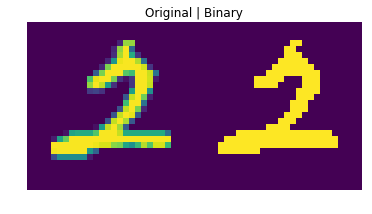

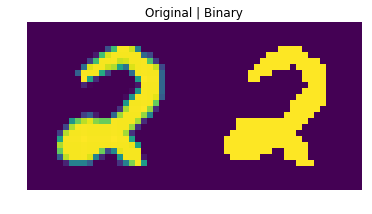

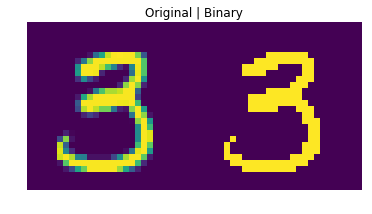

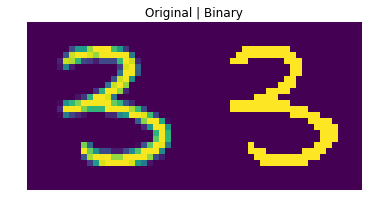

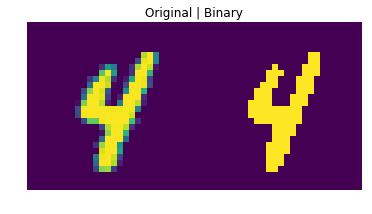

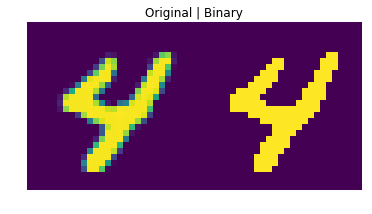

In [58]:
x_binary = 1. * (mnist_images > .5)
x, y = mnist_images, mnist_labels

num_samples = 1
digits = [2,3,4]

for digit in digits:
    sample_idx = np.random.choice(np.where(y == digit)[0], 2)
    for sample_id in sample_idx:
        original, binary = np.reshape(x[sample_id], mnist_dim), np.reshape(x_binary[sample_id], mnist_dim)
        plt.title('Original | Binary')
        plt.axis('off')
        plt.imshow(np.concatenate((original, binary), axis=1))
        plt.show()

### 1.2 Implementation (40)
Write a function ```EM(batch, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters your function should have are:
* ```batch``` :: input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize equations in ```numpy``` as  much as possible and clearly comment in your code where the E-step and where the M-step are performed.

In [96]:
def EM(batch, K, max_iter):
    # Dimension of batch
    N = batch.shape[0]
    
    # Initialize responsabilities
    tau = dict_keys_matrix((N, K), dtype=np.float32)
    
    # Sparse vector of classes for each example
    # i.e. if K=3, classes will be 0,1,2
    classes = np.floor(K*np.random.random((1, N))) 
    
    # Randomly fill values of responsability matrix initially.
    tau[range(N), classes] = 1
    tau = tau.toarray()
    
    # Threshold for stopping optimization
    threshold = 1e-6
    
    # Start EM iterations
    ll = []
    for step in range(max_iter):
        # Efficient way of computing this, reference from
        # https://github.com/PRML/PRMLT/blob/master/chapter09/mixBernEm.m#L28
        
        #### M-STEP ####
        # Obtain normalizing denominator, Bishop 9.57
        Nk = tau.sum(axis=0, keepdims=True).T
        
        # Obtain mixing conefficients, Bishop 9.60
        pi_k = Nk / N
        
        # Obtain estimate for bernoulli parameter, Bishop 9.58, 9.59
        mu = np.dot(batch.T, tau) / Nk.T
        
        #### E-STEP ####
        # Expectation of complete data log-likelihood
        tau = np.dot(batch, np.log(mu+ 1e-10)) + np.dot((1.- batch), np.log(1.-mu + 1e-10)) + np.log(pi).T
        norm = logsumexp(tau, axis=1, keepdims=True)
        tau = np.exp(tau - norm)
        
        # Compute mean log likelihood
        llh = np.mean(norm)
        
        print('{}/{}, mean_ll={}'.format(step, max_iter, llh))
        
        ll.append(llh)
        
        # Check for convergence
        if step > 2 and np.abs(ll[step-1] - ll[step-2]) < threshold * np.abs(ll[step-1]):
            break
        
    return tau, mu, pi_k, ll

### 1.2 Three digits test (10)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits. What are the identified mixing coefficients, and how do these compare to the true ones?

0/100, mean_ll=-202.991426119
1/100, mean_ll=-189.98978614
2/100, mean_ll=-181.105644008
3/100, mean_ll=-180.700383472
4/100, mean_ll=-180.600466854
5/100, mean_ll=-180.519248399
6/100, mean_ll=-180.425254569
7/100, mean_ll=-180.409600422
8/100, mean_ll=-180.393093607
9/100, mean_ll=-180.385095328
10/100, mean_ll=-180.383787948
11/100, mean_ll=-180.382271555
12/100, mean_ll=-180.378200891
13/100, mean_ll=-180.373820471
14/100, mean_ll=-180.371751366
15/100, mean_ll=-180.369979325
16/100, mean_ll=-180.369495376
17/100, mean_ll=-180.369403915
18/100, mean_ll=-180.369326965


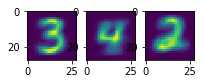

Mixing coefficients are [[ 0.31388606  0.37644216  0.30967178]]
-----------
True mixing coefficients are [ 0.33333334  0.33333334  0.33333334]


In [127]:
def plot_reconstruction(mu, latent_dim): 
    plt.figure(figsize=(latent_dim,1))
    for i in range(latent_dim):
        plt.subplot(1,latent_dim,i+1)
        recons_class = np.reshape(mu[:,i], (28,28))
        plt.imshow(recons_class)
    plt.show()

num_samples = 2000
digits = [2,3,4]
latent_dim = 3

digit_idx = []
for digit in digits:
    digit_idx.extend(np.random.choice(np.where(y == digit)[0], num_samples))

x_batch = x_binary[digit_idx]
y_batch = y[digit_idx]

tau, mu_k, pi_k, ll = EM(x_batch, K=latent_dim, max_iter=100)
plot_reconstruction(mu_k, latent_dim)
true_pi = np.array([sum(y_batch == 2), sum(y_batch == 3), sum(y_batch  == 4)], dtype=np.float32) / y_batch.shape[0]

print('Mixing coefficients are {}'.format(pi_k.T))
print('-----------')
print('True mixing coefficients are {}'.format(true_pi.T))

#### Answer
The mixing coefficients are a close approximation to the true mixing coefficients, which are sampled basically in a uniformly.

### 1.3 More experiments (20)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation.

* __1.3.1__
    Use with more or less classes for $K$.
* __1.3.2__ 
    Use the image labels in ```mnist_labels``` to identify some misclassified images and see if you understand why.
* __1.3.3__ 
    Initialize the three classes with the true values of the parameters and see what happens.

EM for latent dimension 1
0/100, mean_ll=-204.948825259
1/100, mean_ll=-204.948825259
2/100, mean_ll=-204.948825259
3/100, mean_ll=-204.948825259


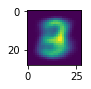

EM for latent dimension 4
0/100, mean_ll=-203.038935818
1/100, mean_ll=-190.433777988
2/100, mean_ll=-184.572346834
3/100, mean_ll=-183.581086444
4/100, mean_ll=-183.102146021
5/100, mean_ll=-182.826046153
6/100, mean_ll=-182.455297197
7/100, mean_ll=-181.887213951
8/100, mean_ll=-180.784237023
9/100, mean_ll=-179.434673077
10/100, mean_ll=-178.091206207
11/100, mean_ll=-177.721372082
12/100, mean_ll=-177.509058202
13/100, mean_ll=-177.393706695
14/100, mean_ll=-177.291741031
15/100, mean_ll=-177.204004437
16/100, mean_ll=-177.139738347
17/100, mean_ll=-177.125698676
18/100, mean_ll=-177.107645628
19/100, mean_ll=-177.037392178
20/100, mean_ll=-177.005757221
21/100, mean_ll=-177.001709477
22/100, mean_ll=-176.994655124
23/100, mean_ll=-176.990863708
24/100, mean_ll=-176.988428776
25/100, mean_ll=-176.986621247
26/100, mean_ll=-176.891991784
27/100, mean_ll=-176.785154829
28/100, mean_ll=-176.735708027
29/100, mean_ll=-176.732843024
30/100, mean_ll=-176.732447872
31/100, mean_ll=-176.73

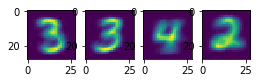

EM for latent dimension 8
0/100, mean_ll=-200.938352424
1/100, mean_ll=-177.185409396
2/100, mean_ll=-171.335113865
3/100, mean_ll=-169.228588684
4/100, mean_ll=-167.526427139
5/100, mean_ll=-166.296917331
6/100, mean_ll=-165.260993884
7/100, mean_ll=-164.554575037
8/100, mean_ll=-164.201799994
9/100, mean_ll=-163.947566856
10/100, mean_ll=-163.738977472
11/100, mean_ll=-163.606270936
12/100, mean_ll=-163.499231437
13/100, mean_ll=-163.44506209
14/100, mean_ll=-163.406328724
15/100, mean_ll=-163.402391114
16/100, mean_ll=-163.397740072
17/100, mean_ll=-163.393263525
18/100, mean_ll=-163.391342055
19/100, mean_ll=-163.383417319
20/100, mean_ll=-163.374255983
21/100, mean_ll=-163.356825866
22/100, mean_ll=-163.352043728
23/100, mean_ll=-163.34843007
24/100, mean_ll=-163.347036094
25/100, mean_ll=-163.341560009
26/100, mean_ll=-163.338998641
27/100, mean_ll=-163.338645123
28/100, mean_ll=-163.338381126
29/100, mean_ll=-163.338142825
30/100, mean_ll=-163.337864932
31/100, mean_ll=-163.3374

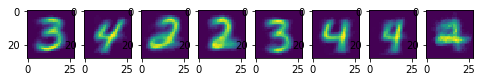

EM for latent dimension 11
0/100, mean_ll=-199.844957876
1/100, mean_ll=-171.241913853
2/100, mean_ll=-161.669727175
3/100, mean_ll=-159.814140686
4/100, mean_ll=-159.261209397
5/100, mean_ll=-158.881296241
6/100, mean_ll=-158.684130679
7/100, mean_ll=-158.561013669
8/100, mean_ll=-158.500118585
9/100, mean_ll=-158.458079231
10/100, mean_ll=-158.373117819
11/100, mean_ll=-158.314362839
12/100, mean_ll=-158.236535574
13/100, mean_ll=-158.195416766
14/100, mean_ll=-158.164316311
15/100, mean_ll=-158.152329775
16/100, mean_ll=-158.147785695
17/100, mean_ll=-158.136050287
18/100, mean_ll=-158.13221938
19/100, mean_ll=-158.131227809
20/100, mean_ll=-158.125068467
21/100, mean_ll=-158.079631572
22/100, mean_ll=-158.067653957
23/100, mean_ll=-158.066557867
24/100, mean_ll=-158.063902021
25/100, mean_ll=-158.062440586
26/100, mean_ll=-158.062348276
27/100, mean_ll=-158.062323133


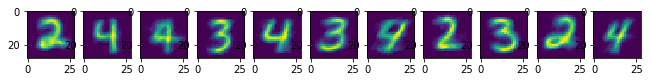

EM for latent dimension 15
0/100, mean_ll=-199.445979497
1/100, mean_ll=-166.941551392
2/100, mean_ll=-158.084239277
3/100, mean_ll=-156.019216302
4/100, mean_ll=-155.308207294
5/100, mean_ll=-154.80528413
6/100, mean_ll=-154.508736273
7/100, mean_ll=-154.33574427
8/100, mean_ll=-154.199555267
9/100, mean_ll=-154.141987879
10/100, mean_ll=-154.080914481
11/100, mean_ll=-154.062650581
12/100, mean_ll=-154.042424701
13/100, mean_ll=-154.026028134
14/100, mean_ll=-153.994700218
15/100, mean_ll=-153.972259763
16/100, mean_ll=-153.959696891
17/100, mean_ll=-153.940858151
18/100, mean_ll=-153.881867137
19/100, mean_ll=-153.858983829
20/100, mean_ll=-153.814508674
21/100, mean_ll=-153.704911825
22/100, mean_ll=-153.647016481
23/100, mean_ll=-153.610566457
24/100, mean_ll=-153.596209805
25/100, mean_ll=-153.587430134
26/100, mean_ll=-153.577617719
27/100, mean_ll=-153.530603203
28/100, mean_ll=-153.475837064
29/100, mean_ll=-153.436583715
30/100, mean_ll=-153.421441541
31/100, mean_ll=-153.384

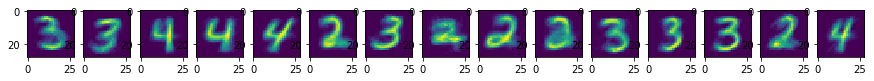

In [116]:
### 1.3 - Use with more or less classes for K
latent_dim_values = list(np.linspace(1, 15, 5, dtype=np.int32))
for ki in latent_dim_values:
    print('EM for latent dimension {}'.format(ki))
    tau, mu_k, pi_k, ll = EM(x_batch, K=ki, max_iter=100)
    plot_reconstruction(mu_k, ki)

#### Answer:

Theoretically increasing K would increase the flexibility of the posterior, however the maximum number of classes is 3 in this case. So anything below K=3 the classes are less separated and are the results of mixtures, while with more than 3 we observe a slightly better convergence in terms of log likelihood, and some digits occuring in multiple class reconstructions.

0/200, mean_ll=-202.825663487
1/200, mean_ll=-192.343636666
2/200, mean_ll=-186.685849171
3/200, mean_ll=-184.069431045
4/200, mean_ll=-183.00840219
5/200, mean_ll=-182.630527869
6/200, mean_ll=-182.234296573
7/200, mean_ll=-181.797789511
8/200, mean_ll=-181.432476488
9/200, mean_ll=-181.157853461
10/200, mean_ll=-180.988911105
11/200, mean_ll=-180.901468537
12/200, mean_ll=-180.784213618
13/200, mean_ll=-180.715645129
14/200, mean_ll=-180.68140006
15/200, mean_ll=-180.637378116
16/200, mean_ll=-180.598434598
17/200, mean_ll=-180.498252109
18/200, mean_ll=-180.472506509
19/200, mean_ll=-180.469306469
20/200, mean_ll=-180.462061106
21/200, mean_ll=-180.460548323
22/200, mean_ll=-180.458591515
23/200, mean_ll=-180.456168297
24/200, mean_ll=-180.452816408
25/200, mean_ll=-180.449079231
26/200, mean_ll=-180.447621023
27/200, mean_ll=-180.446310087
28/200, mean_ll=-180.445642288
29/200, mean_ll=-180.4454046
30/200, mean_ll=-180.445282563
31/200, mean_ll=-180.445208743


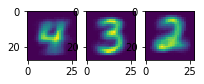

In [129]:
# 1.3.2 - Use the image labels in mnist_labels to identify some 
# misclassified images and see if you understand why.
tau, mu_k, pi_k, ll = EM(x_batch, K=3, max_iter=200)
plot_reconstruction(mu_k, 3)

Classified as 3, True class 2


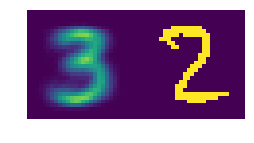

Classified as 4, True class 2


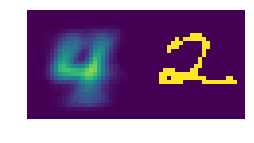

Classified as 4, True class 2


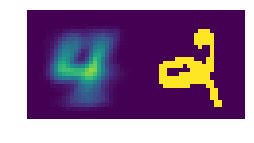

Classified as 3, True class 2


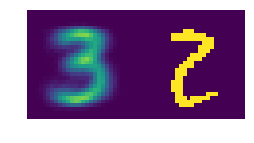

Classified as 4, True class 2


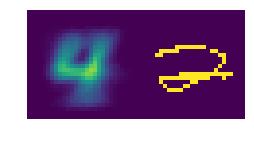

Classified as 2, True class 3


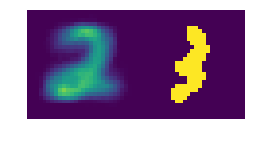

Classified as 4, True class 2


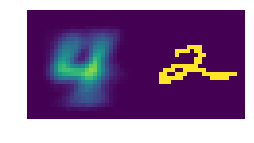

Classified as 3, True class 4


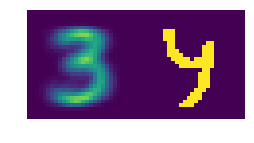

Classified as 3, True class 2


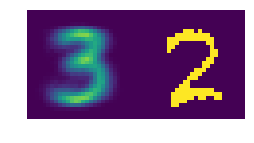

In [144]:
# CHANGE this for every model trained! Look at the image above to define mapping from mu_k to true labels
m = {0:3, 1:4, 2:2}

def map_digit(i):
    if i == 0:
        return 4
    elif i == 1:
        return 3
    elif i == 2:
        return 2
    else:
        raise Exception('Define this function with specific values after you have ran EM.')

for i in range(100):
    img = np.random.choice(x_batch.shape[0]) # randomly select image
    assigned_class = np.argmax(tau[img,:])
    y_out = map_digit(assigned_class)
    y_true = y_batch[img]
    if (y_out != y_true):
        print('Classified as {}, True class {}'.format(y_out, y_true))
        
        orig_im = np.reshape(x_batch[img], mnist_dim)
        reconstructed_im = np.reshape(mu_k[:,assigned_class], mnist_dim)
        plt.figure(figsize=(4,2))
        plt.imshow(np.concatenate((reconstructed_im, orig_im), axis=1))
        plt.axis('off')
        plt.show()

### Answer:

Purely written digits are miclassified, as they are outside of the distribution of their true class (or on a space in the manifold with a very low probability mass).

0/100, mean_ll=-181.216349378
1/100, mean_ll=-180.573502722
2/100, mean_ll=-180.453889107
3/100, mean_ll=-180.436775257
4/100, mean_ll=-180.4338044
5/100, mean_ll=-180.421661202
6/100, mean_ll=-180.409810721
7/100, mean_ll=-180.407580467
8/100, mean_ll=-180.406347089
9/100, mean_ll=-180.406202185
10/100, mean_ll=-180.406176006


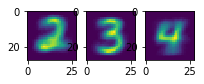

In [151]:
def EM_true(batch, K, max_iter, y_batch):
    # Dimension of batch
    N = batch.shape[0]
    
    # Initialize responsabilities
    tau = dict_keys_matrix((N, K), dtype=np.float32)
    
    # Initialize classes under given labels in batch_y
    names = list(set(y_batch))
    d = {}
    for ci in range(len(names)):
        d[names[ci]] = ci
    classes = np.array([d[ci] for ci in y_batch])
    
    # Randomly fill values of responsability matrix initially.
    tau[range(N), classes] = 1
    tau = tau.toarray()
    
    # Threshold for stopping optimization
    threshold = 1e-6
    
    # Start EM iterations
    ll = []
    for step in range(max_iter):
        # Efficient way of computing this, reference from
        # https://github.com/PRML/PRMLT/blob/master/chapter09/mixBernEm.m#L28
        
        #### M-STEP ####
        # Obtain normalizing denominator, Bishop 9.57
        Nk = tau.sum(axis=0, keepdims=True).T
        
        # Obtain mixing conefficients, Bishop 9.60
        pi_k = Nk / N
        
        # Obtain estimate for bernoulli parameter, Bishop 9.58, 9.59
        mu = np.dot(batch.T, tau) / Nk.T
        
        #### E-STEP ####
        # Expectation of complete data log-likelihood
        tau = np.dot(batch, np.log(mu+ 1e-10)) + np.dot((1.- batch), np.log(1.-mu + 1e-10)) + np.log(pi).T
        norm = logsumexp(tau, axis=1, keepdims=True)
        tau = np.exp(tau - norm)
        
        # Compute mean log likelihood
        llh = np.mean(norm)
        
        print('{}/{}, mean_ll={}'.format(step, max_iter, llh))
        
        ll.append(llh)
        
        # Check for convergence
        if step > 2 and np.abs(ll[step-1] - ll[step-2]) < threshold * np.abs(ll[step-1]):
            break
        
    return tau, mu, pi_k, ll

num_samples = 5000
digits = [2,3,4]
latent_dim = 3

digit_idx = []
for digit in digits:
    digit_idx.extend(np.random.choice(np.where(y == digit)[0], num_samples))

x_batch = x_binary[digit_idx]
y_batch = y[digit_idx]

tau, mu_k, pi_k, ll = EM_true(x_batch, K=latent_dim, max_iter=100, y_batch=y_batch)
plot_reconstruction(mu_k, latent_dim)

### Answer

Obviously the convergence is almost immediate given the true classes. In our experiments if the number of smaples increases, the number of iterations needed to converge is slighty larger.

### 1.4 Relation to Variational Inference (5)
Propose how you would alter the Bernoulli mixture model for use with a variational method (Bishop Ch.$10$). 

Which priors would you use and why? 

In a variational inference setting the parameters of the model now become random variables, and have associated probability distributions, therefore they require prior distribution for a bayesian treatment to be compelte. 

From bishop 2.1.1 and 2.2.1 we would choose conjugate priors for $\mu$ and $\pi$, i.e. Beta and Dirichlet respectively.

## Part 2: Variational Auto-Encoder
A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part, that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

More information can be found here:
* Original paper by Kingma (2014) https://arxiv.org/pdf/1312.6114.pdf 
* Nice but large summary (2016) https://arxiv.org/pdf/1606.05908.pdf
* One of _many_ online Tutorials, i.e. https://jaan.io/what-is-variational-autoencoder-vae-tutorial or http://kvfrans.com/variational-autoencoders-explained

### 2.1 The q-distribution (5 points)

In variational inference, we introduce distribution $q(\theta)$ over parameters / latent variables in order to make inference tractable. We can think of $q$ as being an approximation of a certain distribution. What function does $q$ approximate, $p(\bx|\theta)$, $p(\theta|\bx)$, $p(\bx, \theta)$, $p(\theta)$, or $p(\bx)$, and how do you see that from the equation $\ln p(\bx) = \mathcal{L}(q) + \mathrm{KL}(q||p)$? 


**Answer**: **q** approximates the posterior distribution of the latent variables (in this case represented as $\theta$) conditioned on the observed variables (x), i.e. $P(\theta|x)$. To explain the last formula, let's start by considering what we are trying to achieve. Given a posterior distribution that is intractable due to working in a high dimensional regime, or not having a computable analytic form, we posit a family of distributions $q$ with the intention of constructing an approximate distribution as close as possible to the posterior (where 'closeness' is measured by KL divergence). We therefore want $q^{*} = argmin_{q} KL(q(\theta)|p(\theta|x))$:

$$KL(q(\theta)|p(\theta|x)) = E_{q(\theta)}[log q(\theta) - log p(\theta|x)]$$

We apply Bayes theorem to the second component of the expectation:

$$KL(q(\theta)|p(\theta|x)) = E_{q(\theta)}[log q(\theta) - log(p(\theta,x) + log p(x)]$$

Notice further that the log of the marginal likelihood $log p(x)$ does not depend on $\theta$:

$$KL(q(\theta)|p(\theta|x)) = E_{q(\theta)}[log q(\theta) - log(p(\theta,x)] + log p(x)$$

If we multiply the expression by -1 on both sides and isolate the log of the marginal likelihood we obtain:

$$log p(x) = E_{q(\theta)}[log(p(\theta,x) - log q(\theta)] + KL(q||p)$$
$$log p(x) = L(q) + KL(q||p)$$

The first component is the evidence lower bound. It serves a lower bound for the marginal log likelihood, and maximizing it is equivalent to minimizing the KL divergence between the approximate and true posterior (to see why the equivalence holds, consider that KL is always $\geq$ 0 and $log p(x)$ is independent of the variational parameters found in $q(\theta)$.

### 2.2 Implementation (20 points)
Above is a version of a Variational Auto-Encoder that uses PyTorch (http://pytorch.org/). PyTorch is python package that is  particularly suited for high level programming of neural net, and is easily installable by following the instructions on their website.

Add comments to the code below, where each ```COMMENT``` line should be replaced with an explanation of the code on the line below it (this may also be one or two words) and specify the encoder and decoder parts. 

Modify the ```run(...)``` function to visualize each $200$ iterations how the model is improving. Do this by sampling a few values of the latent space $\bz$ and running those through the decoder. Add a plot of the loss function and show this after convergence. Run the 

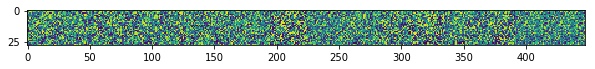

0/1000, loss = 778.26739502


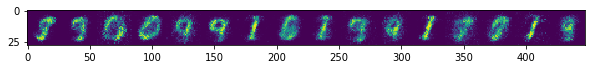

200/1000, loss = 195.274765015


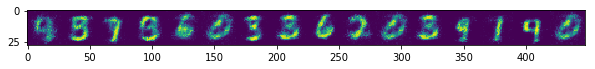

400/1000, loss = 162.019073486


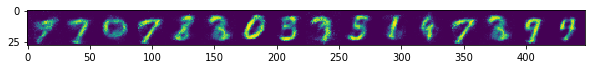

600/1000, loss = 156.798187256


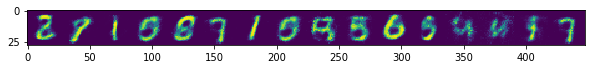

800/1000, loss = 143.155883789


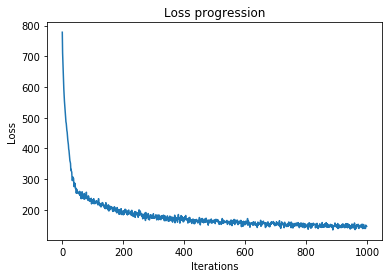

In [174]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable

## Set number of samples and data dimension to MNIST format
N_samples, X_dim = mnist_images.shape
## Set minibatch size
mb_size = 64
## Set dimensions of latent variable ("code")
Z_dim = 100
## Set dimensions of hidden layer
h_dim = 128
## Set learning rate
lr = 1e-3

# Add regularization
weight_decay = 1e-6

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

## Initialize model parameters for the encoder
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## Encoder neural network.
## Compute parameters for distribution over latent variables.
## This network approximates the parametrized posterior distribution
## p(z|x) by learning its parameters.
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1))
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

## Sample from the latent variable distribution of Z, or more specifically
## the approximation learned by Q(X). Using the learned parameters, the parametrized
## Gaussian distribution can be sampled.
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps

## Initialize model parameters for the decoder
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## Decoder neural network.
## Compute the decoded variable X.
## This network generates an observation given a latent variable, which
## is an approximation of p(X|z) here.
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## Set the parameters to be learned with a set learning rate.
## Adagrad adapts its learning rate for improved optimization over standard SGD.

## NOTE: Modifeid to use ADAM (Kingma++).
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

def run(num_iter, visualize_step=200, n_vis=3):
    losses = []
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## First, sample from the approximated parametrized posterior distribution, of which the
        ## parameters are learned by the encoder network. Second, use the samples as input for
        ## the decoder network to generate the observations.
        z_mu, z_var = Q(X)
        z = sample_z(z_mu, z_var)

        X_sample = P(z)

        ## Define the reconstruction loss, which represents the difference between the input X and
        ## the resulting decoded hidden state X_sample
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        
        ## Define the Kullback-Leibler loss, which acts as a regularizer to limit the divergence of the
        ## encoder distribution from a standard normal distribution.
        ## That ensures that the variance of the Gaussian distributions does not stray away too much.
        ## If it would stray, we would no longer have a general model that captures highly similar observations
        ## by the same region in the latent space.
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss

        ## Use autograd to compute the backward pass, computing the gradient of our defined loss.
        ## This is done with respect to all variables with the requires_grad=True attribute.
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()

        losses.append(loss.data.numpy()[0])
        if iter % visualize_step == 0:         
            z = sample_z(z_mu, z_var)
            X_sample = P(z).data.numpy()
            X_sample = np.reshape(X_sample, (mb_size, int(np.sqrt(X_dim)), int(np.sqrt(X_dim))))
            concat = X_sample[0,:,:]
            for j in np.random.choice(mb_size - 1, 15):
                concat = np.concatenate((concat, X_sample[j+1, :,:]), axis = 1)
            plt.figure(figsize=(10,9))
            plt.imshow(concat)
            plt.show()
            print("{}/{}, loss = {}".format(iter,num_iter,losses[iter-1]))
    plt.figure()
    plt.plot(range(len(losses)), losses)
    plt.title('Loss progression')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()
    return losses

_ = run(1000)

### 2.3 Visualize latent space (15)
Implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space. 

Compare your result to Kingma 2014, Appendix A. What are the differences and why?

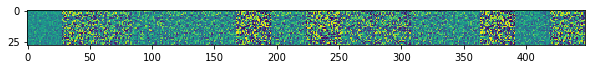

0/15000, loss = 745.001098633


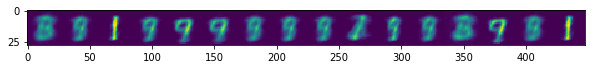

1000/15000, loss = 171.240905762


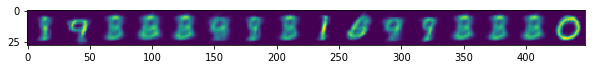

2000/15000, loss = 172.737045288


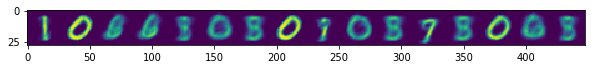

3000/15000, loss = 170.57762146


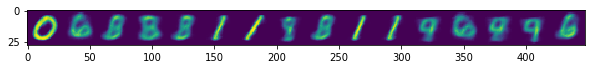

4000/15000, loss = 162.996612549


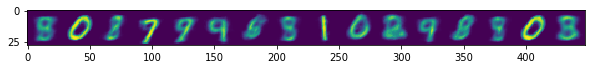

5000/15000, loss = 160.692611694


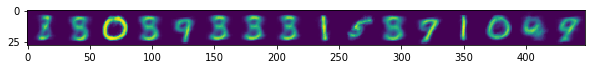

6000/15000, loss = 148.966766357


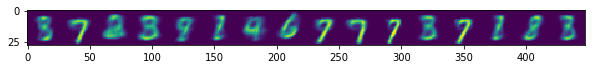

7000/15000, loss = 155.597122192


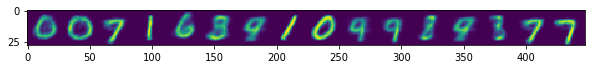

8000/15000, loss = 140.860321045


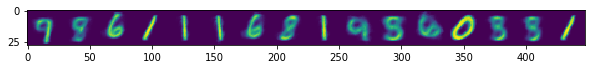

9000/15000, loss = 158.34727478


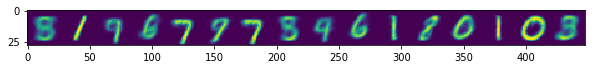

10000/15000, loss = 142.534744263


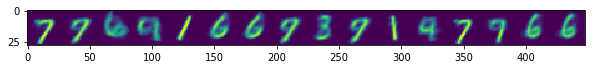

11000/15000, loss = 150.966705322


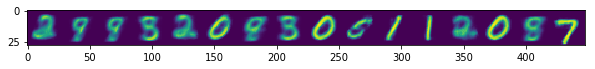

12000/15000, loss = 149.345321655


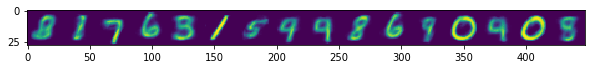

13000/15000, loss = 140.73840332


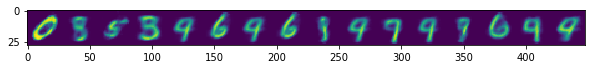

14000/15000, loss = 149.937454224


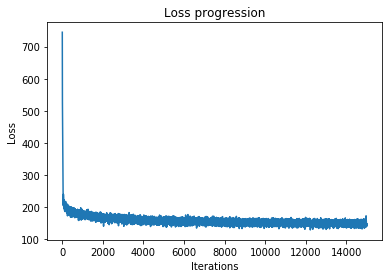

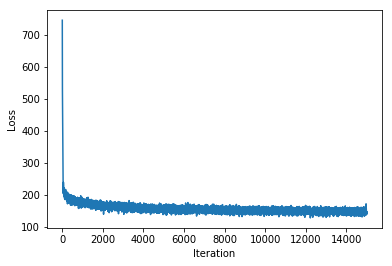

In [180]:
## Set number of samples and data dimension to MNIST format
N_samples, X_dim = mnist_images.shape
## Set minibatch size
mb_size = 64
## Set dimensions of latent variable ("code")
Z_dim = 2
## Set dimensions of hidden layer
h_dim = 128
## Set learning rate
lr = 1e-3
## Iterations
num_iters = 15000

def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## Initialize model parameters for the encoder
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## Initialize model parameters for the decoder
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## Set the parameters to be learned with a set learning rate.
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

losses = run(num_iters, visualize_step=1000)

# Plot loss
plt.plot(range(len(losses)), losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

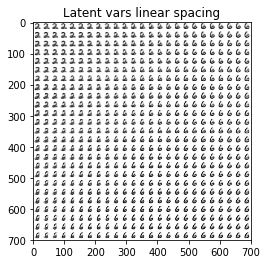

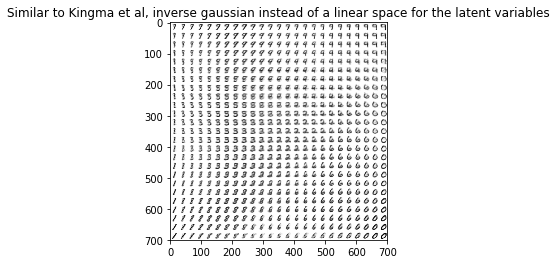

In [186]:
from scipy.stats import norm

n = 25        
step = 1.0/n
unit_grid = np.mgrid[0 + step/2:1 + step/2:step, 0 + step/2:1 + step/2:step].reshape(2,-1).T
cdf_grid = norm.ppf(unit_grid)
z = Variable(torch.FloatTensor(unit_grid))
manifolds = P(z)

imgs = []
for manifold in manifolds:
    imgs.append(1-np.reshape(manifold.data.numpy(), [28, 28]))

final_img = np.zeros([28*n, 28*n])
for i in range (0, len(imgs)):
    r_i = (i % n)*28
    c_i = (i/n)*28
    final_img[r_i : (r_i + 28), c_i : (c_i + 28)] = imgs[i]
    

imshow(final_img, cmap='gray')
title("Latent vars linear spacing")
plt.figure(figsize=(12,12))
plt.show()

cdf_grid = norm.ppf(unit_grid)
z = Variable(torch.FloatTensor(cdf_grid))
manifolds = P(z)

imgs = []
for manifold in manifolds:
    imgs.append(1-np.reshape(manifold.data.numpy(), [28, 28]))

final_img = np.zeros([28*n, 28*n])
for i in range (0, len(imgs)):
    r_i = (i % n)*28
    c_i = (i/n)*28
    final_img[r_i : (r_i + 28), c_i : (c_i + 28)] = imgs[i]
    
title("Similar to Kingma et al, inverse gaussian instead of a linear space for the latent variables")
imshow(final_img, cmap='gray')
plt.figure(figsize=(6,6))
plt.show()